In [73]:
## code to model the thermal response of a house during winter

In [74]:
import math
import cmath
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


import scienceplots
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [75]:
# price parameters: 
electricity_price = 0.12 # [USD/kWh]
gas_price = 0.04 # [USD/kWh]
fixed_gas_fee = 30*0 # [USD/kWh]
fixed_electric_fee = 10*0 # [USD/kWh]

# Model parameters: 

target_temp=19
house_mass=40000*1  # kg (adjusted to be more realistic for thermal inertia)
specific_heat_cap =1000  # J/kg-K
heat_capacity = specific_heat_cap*house_mass # J/K
#heat_capacity = 2*1000.0*3600 # J/K

# A well-insulated wood-frame house: 20 - 100 kWh/°C
# A house with significant brick or concrete elements: 100 - 500 kWh/°C
# A passive house or very heavy construction: 500+ kWh/°C


thermal_conductance=150  # W/K (adjusted for typical home insulation) - 3 therm per day (Jaime)
thermal_conductance=220  # W/K (adjusted for typical home insulation) - 4.5 therm per day (Fotis)


furnace_BTU = 125000 # [BTU/hr]
max_power_furnace=1000*0.000293071*furnace_BTU  # W (max power of heating system)
furnace_efficiency=0.97  # Efficiency of furnace

max_power_heat_pump=8000  # W (max power of heating system)
heat_pump_cop=2.5  # Coefficient of performance for heat pump



# select heating mode
heating_type='furnace'  # 'furnace' or 'heat_pump'
#heating_type='heat_pump'  # 'furnace' or 'heat_pump'



In [76]:
if heating_type == 'heat_pump':
    # Load the data
    df = pd.read_csv("bosch_ids_ultra_cop.csv")
    
    # Extract columns
    temps_c = df["Outdoor Temperature (°C)"].values
    COP_values = df["COP"].values
    
    # Plot the data
    plt.figure(figsize=(8, 5))
    plt.plot(temps_c, COP_values, marker='o', linestyle='-', color='b', label='COP vs. Outdoor Temp')
    plt.xlabel("Outdoor Temperature (°C)")
    plt.ylabel("Coefficient of Performance (COP)")
    plt.title("COP of Bosch IDS Ultra Heat Pump")
    plt.axhline(y=1, color='r', linestyle='--', label="COP = 1 (Resistance Heating)")
    plt.grid(True)
    plt.legend()
    plt.show()

In [77]:
# generate time vector and temperature profile
dt = 60*1
hours = 24
time = np.arange(0, hours * 3600 + dt, dt)  #  [s] time vector
T_av = -5 # [C] average temperature 
T_var = 10 # [C] variation
temp_profile = T_av + T_var/2 * np.sin(2 * np.pi * time / 24 / 3600)  # [C] temperature vector

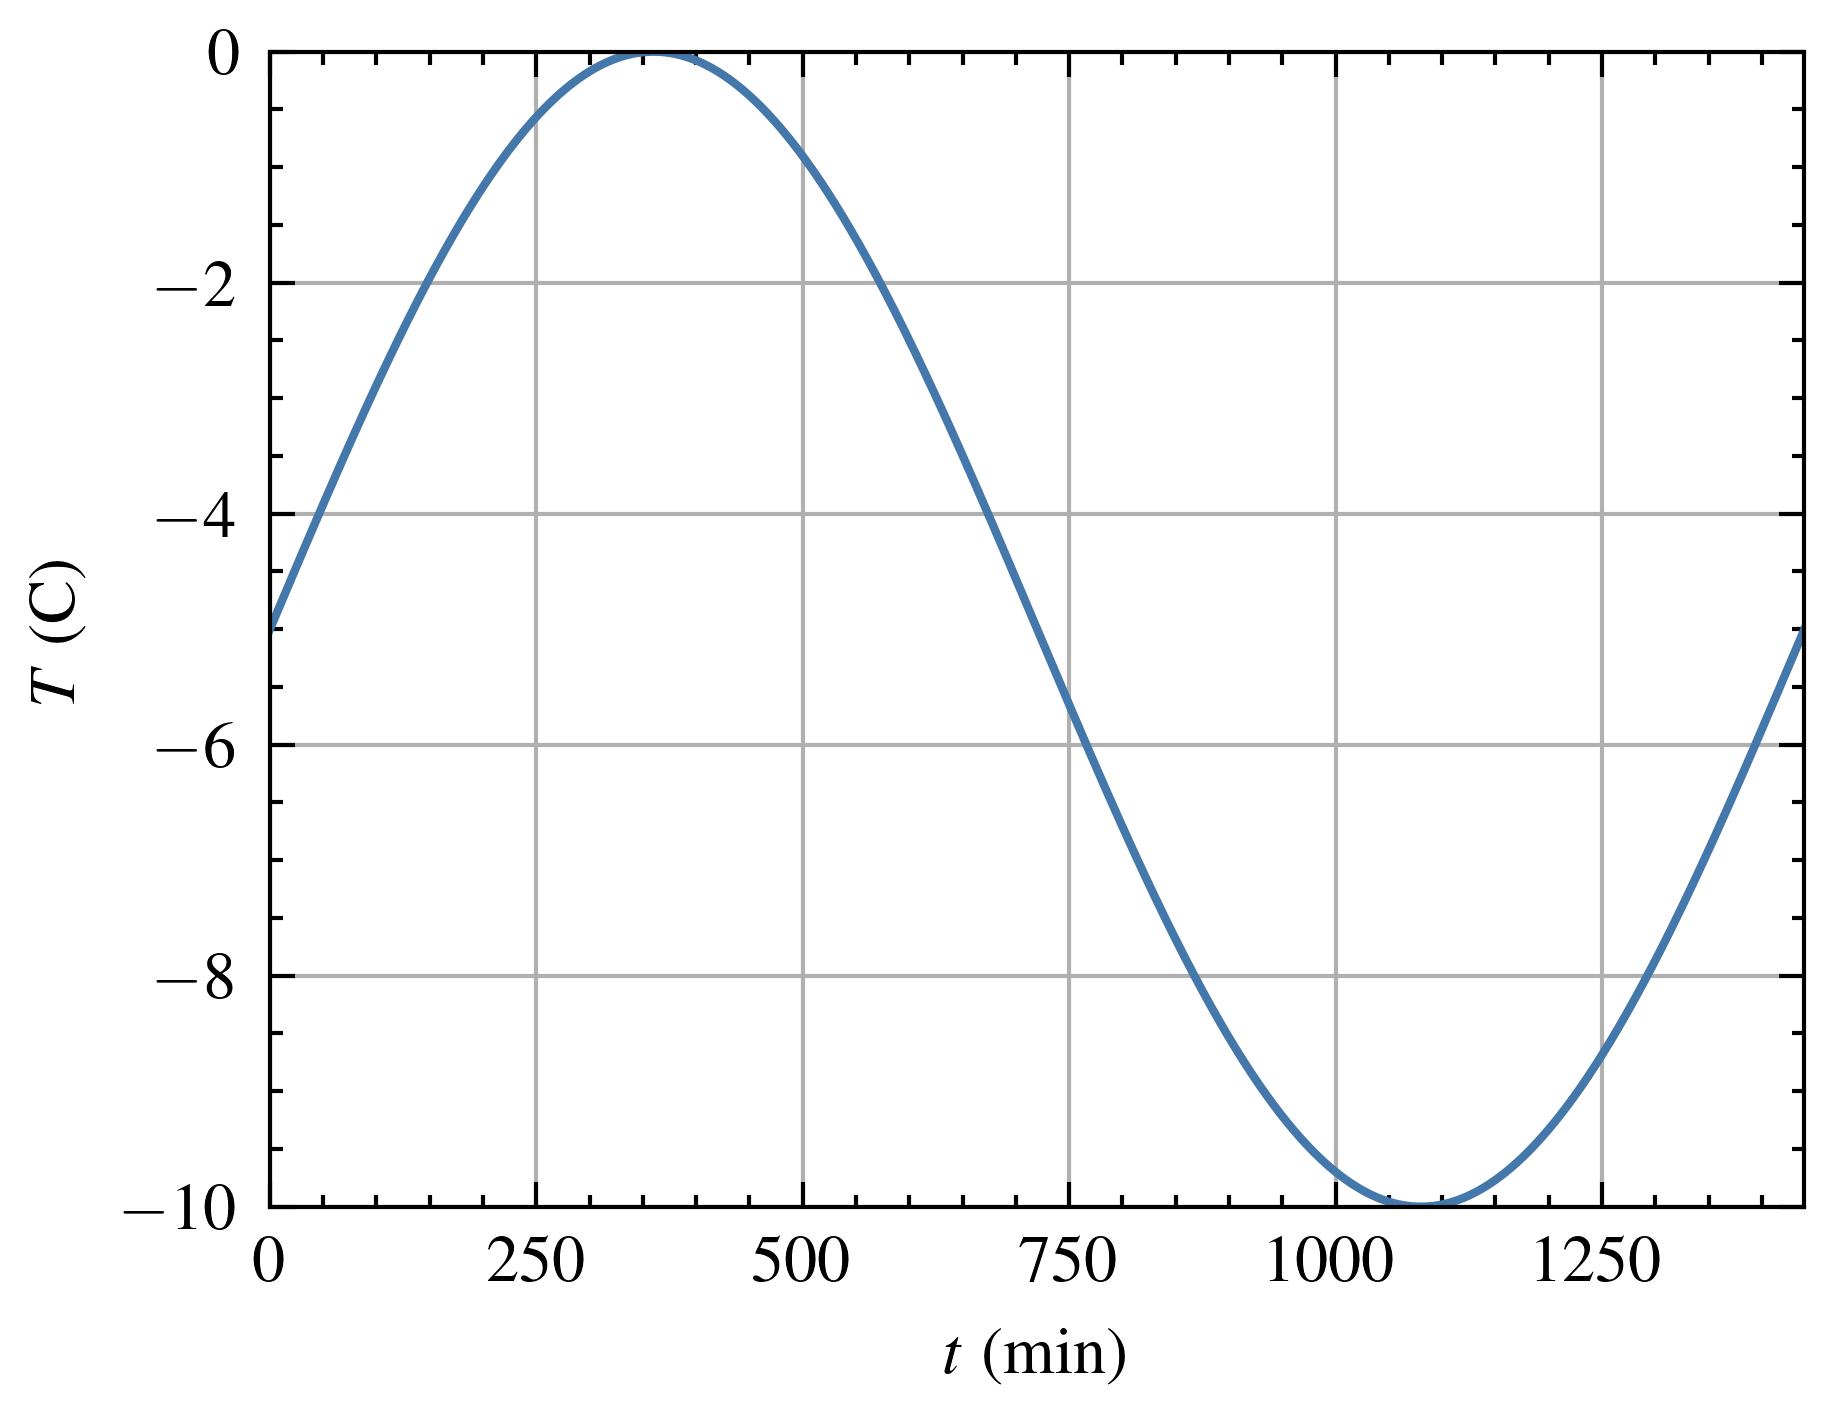

In [78]:
pparam = dict(xlabel=r'$t$ (min)', ylabel=r'$T$ (C)')

with plt.style.context(['science','ieee','scatter','bright']):
#with plt.style.context(['science', 'ieee', 'std-colors']):
#with plt.style.context(['science', 'ieee', 'high-vis']):
    fig, ax = plt.subplots()
    ax.plot(time/60, temp_profile)

    #ax.legend((label_1, label_2,label_3))
    ax.autoscale(tight=True)
    #ax.set_aspect('equal', adjustable='box')
    ax.set(**pparam)
    #ax.set_xlim([-1, 1])
    #ax.set_ylim([-45, 45])
    ax.grid()
    #fig.savefig('trajectory.eps', dpi=300)
    #fig.savefig('trajectory.png', dpi=300)
    plt.show()

In [79]:
# simulation for the time interval: 
num_steps = len(time)
indoor_temp = np.zeros(num_steps)
heating_status = np.zeros(num_steps)  # Track heating power (on/off)
indoor_temp[0] = target_temp  # Start at target temperature
energy_used = 0  # Total energy used in kWh
min_t_on = 0*60 # [s] minimum on time
control_threshold = 0.5

outdoor_temp = temp_profile

last_t_on = 0

for count_t in range(1, num_steps):
    heat_input = 0
    heat_loss = thermal_conductance * (indoor_temp[count_t - 1] - outdoor_temp[count_t - 1]) * dt

    if indoor_temp[count_t - 1] < target_temp - control_threshold and heating_status[count_t-1] == 0:
        heating_status[count_t] = 1
    elif indoor_temp[count_t - 1] < target_temp + control_threshold and heating_status[count_t-1] == 1:
        heating_status[count_t] = 1

    if heating_status[count_t]-heating_status[count_t-1] == 1:
        last_t_on = time[count_t]

    if time[count_t] - last_t_on <= min_t_on:
        heating_status[count_t] = 1

    if heating_status[count_t] == 1: 
        if heating_type == 'heat_pump':
            heat_input = (max_power_heat_pump * heat_pump_cop) * dt  # [J] Adjusted for COP
            energy_used += (max_power_heat_pump*dt / (3.6e6))  # Convert J to kWh (electricity input already adjusted for COP)
            cost_per_kwh = electricity_price
        else:
            heat_input = max_power_furnace * furnace_efficiency * dt  # [J] Adjusted for furnace efficiency
            energy_used += (max_power_furnace*dt / (furnace_efficiency * 3.6e6))  # Convert J to kWh
            cost_per_kwh = gas_price
        
    delta_energy = heat_input - heat_loss
    delta_temp = delta_energy / heat_capacity
    indoor_temp[count_t] = indoor_temp[count_t - 1] + delta_temp

    
total_cost = energy_used * cost_per_kwh


In [80]:
average_heating = np.mean(heating_status)

print(f"Average hours heating on: {24*average_heating:.2f}")

Average hours heating on: 3.45


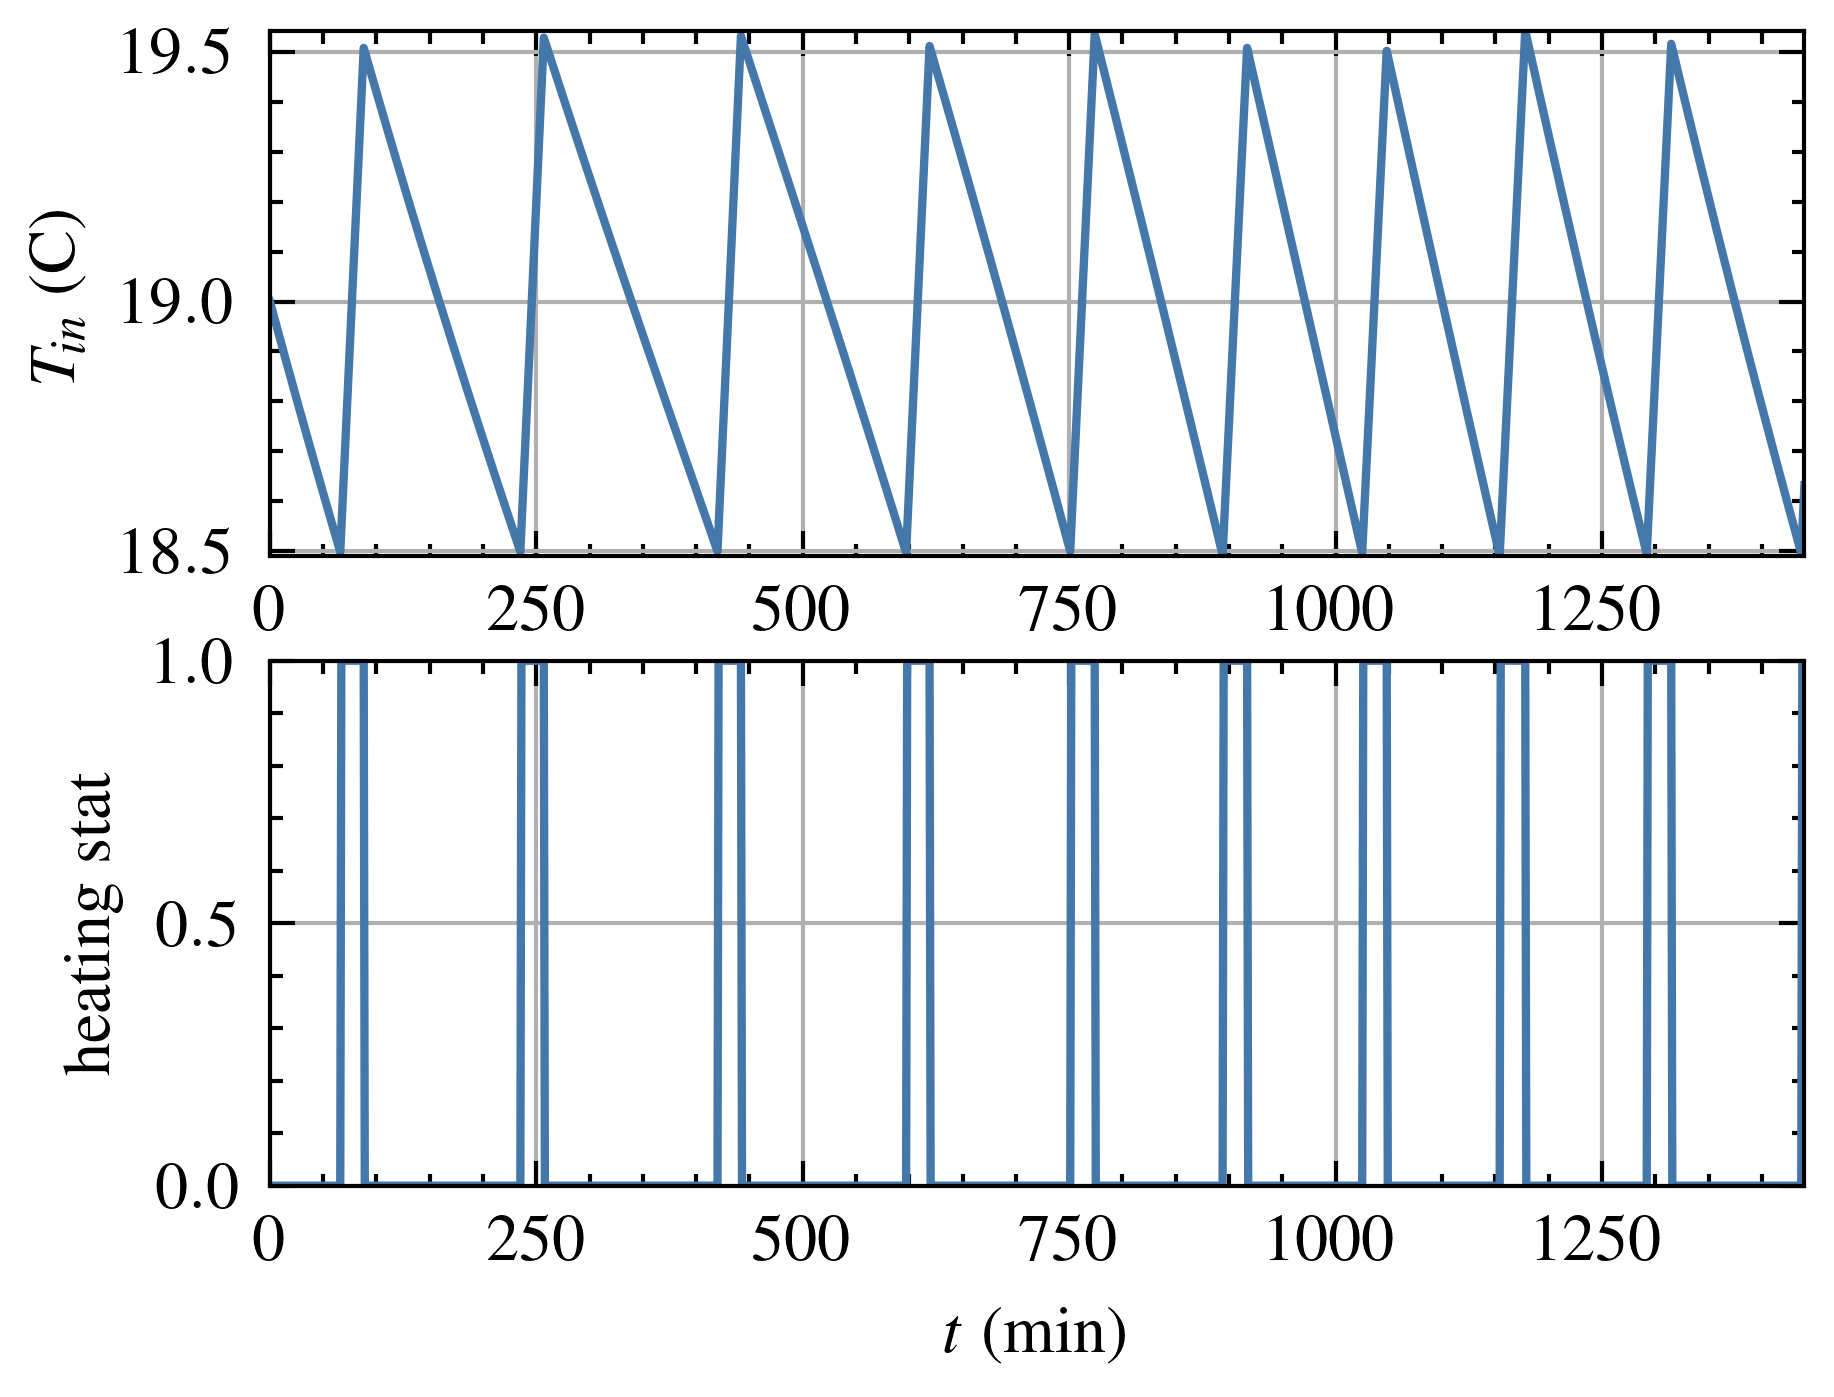

In [81]:
pparam1 = dict(xlabel=r'$t$ (min)', ylabel=r'$T_{out}$ (C)')
pparam2 = dict(xlabel=r'$t$ (min)', ylabel=r'$T_{in}$ (C)')
pparam3 = dict(xlabel=r'$t$ (min)', ylabel=r'heating stat')

#with plt.style.context(['science','ieee','scatter','bright']):
with plt.style.context(['science','ieee','bright']):
#with plt.style.context(['science', 'ieee', 'std-colors']):
#with plt.style.context(['science', 'ieee', 'high-vis']):
    fig, ax = plt.subplots(2)
    ax[0].plot(time/60, indoor_temp)
    #ax.legend(title='Order')
    ax[0].autoscale(tight=True)
    ax[0].set(**pparam2)
    ax[0].grid()
    
    ax[1].plot(time/60, heating_status)
    #ax.legend(title='Order')
    ax[1].autoscale(tight=True)
    ax[1].set(**pparam3)
    ax[1].grid()
    
    fig.savefig('temp_heating_profile.png', dpi=300)
    plt.show()

In [82]:
def calculate_monthly_bill(energy_used, heating_type, electricity_cost=0.12, gas_cost=0.04, fixed_gas_cost=30, fixed_electric_cost=10):
    if heating_type == 'furnace':
        usage_cost = energy_used * gas_cost
        total_cost = usage_cost + fixed_gas_cost + fixed_electric_cost
    else:
        usage_cost = energy_used * electricity_cost
        total_cost = usage_cost + fixed_electric_cost
    
    return total_cost

In [83]:
print(f"Total energy used daily: {energy_used:.2f} kWh")
print(f"Total energy used daily: {energy_used/0.000293/1000:.2f} kBTU")
print(f"Total energy used daily: {energy_used/0.000293/99976.1:.2f} therm")
print(f"Total daily cost: ${total_cost:.2f}")

monthly_bill = calculate_monthly_bill(energy_used * 30, heating_type, electricity_price, gas_price, fixed_gas_fee, fixed_electric_fee)

print(f"Estimated monthly bill: ${monthly_bill:.2f}")

Total energy used daily: 130.30 kWh
Total energy used daily: 444.70 kBTU
Total energy used daily: 4.45 therm
Total daily cost: $5.21
Estimated monthly bill: $156.35


In [84]:
# verification of energy and cost: 

if heating_type == 'heat_pump':
    E = average_heating*max_power_heat_pump/1000*24*30
    print(f"Total energy used daily: {E/30:.2f} kWh")
    print(f"Total monthly cost: ${E*electricity_price:.2f}")
else:
    E = average_heating*furnace_BTU*24*30
    print(f"Total energy used daily: {E/30/1000:.2f} kBTU")
    print(f"Total energy used daily: {E/30/99976.1:.2f} therm")
    print(f"Total monthly cost: ${E*gas_price*0.000293:.2f}")
    



Total energy used daily: 430.95 kBTU
Total energy used daily: 4.31 therm
Total monthly cost: $151.52
